In [5]:
import numpy as np
import matplotlib.pyplot as plt
import emcee 
import time
import corner

In [6]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\Data\transient.npy")

In [7]:
Time = data.T[0]
vals = data.T[1]
errs = data.T[2]

In [8]:
# Define the likelihood function (PDF)
def pdf(x):
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    output = np.where(Time > x[3], x[1] + x[0] * np.exp(-x[2] * (Time - x[3])), x[1])
    return output

def func(Time,A,b,alpha,t0):
    output = np.where(Time > t0, b + A * np.exp(-alpha * (Time -t0)),b)
    return output

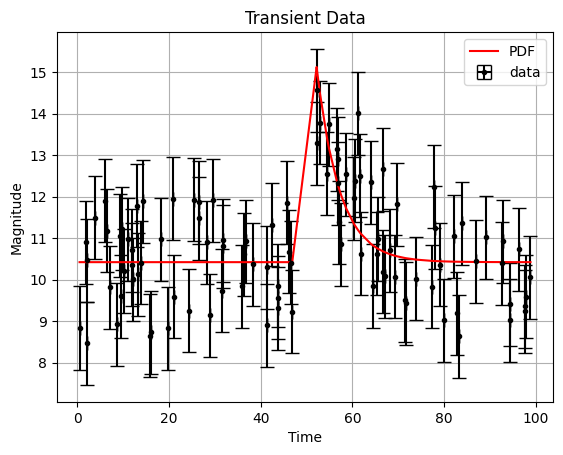

In [20]:
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.plot(Time,func(Time,*np.array([max(vals)/2,vals[:20].mean(),0.2,50])), color='red', label="PDF")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

In [21]:
def prior(x):
    
    if (0 < x[0] < 50) and (0 < x[1] < 50) and (0 < x[3] < 100) and (np.exp(-5) < x[2] < 1):
        return 1/50 * 1/50 * 1/100 * 1/10 * 1/x[2]
    
def posterior(x):
    """
    Compute the log posterior, which is the sum of the log-likelihood and log-prior.
    
    Parameters
    ----------
    x : list or np.array
        The parameters [A, b, alpha, x0].
    
    Returns
    -------
    float
        The log posterior.
    """
    # Calculate the likelihood (PDF)
    log_like = pdf(x)
    
    # If log_like is invalid (None or empty), return -inf
    if log_like is None or np.any(np.isnan(log_like)) or np.any(log_like == 0):
        return -np.inf
    
    # Calculate the log-prior
    log_prior_value = prior(x)
    
    # If prior is invalid (None or outside bounds), return -inf
    if log_prior_value is None or log_prior_value == 0:
        return -np.inf
    
    # If both likelihood and prior are valid, compute the log-posterior
    return np.sum(np.log(log_like)) + np.log(log_prior_value)

     

In [22]:
ndim     = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nsteps   = int(2*1e5)  # number of MCMC steps to take **for each walker**

In [23]:
guess_parameters = np.array([max(vals)/2,vals[:20].mean(),0.2,50])
starting_guesses = guess_parameters+1e-6*np.random.randn(nwalkers, ndim)

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
elapsed=time.time()
print("Starting MCMC...")
sampler.run_mcmc(starting_guesses, nsteps)
print("MCMC finished in %s seconds" % (time.time() - elapsed))

Starting MCMC...


MCMC finished in 604.5553865432739 seconds


In [25]:
tau = sampler.get_autocorr_time()

In [26]:
print(tau)

[168.73087543 131.05288011 126.39548567 209.97650862]


In [27]:
samples = sampler.get_chain()

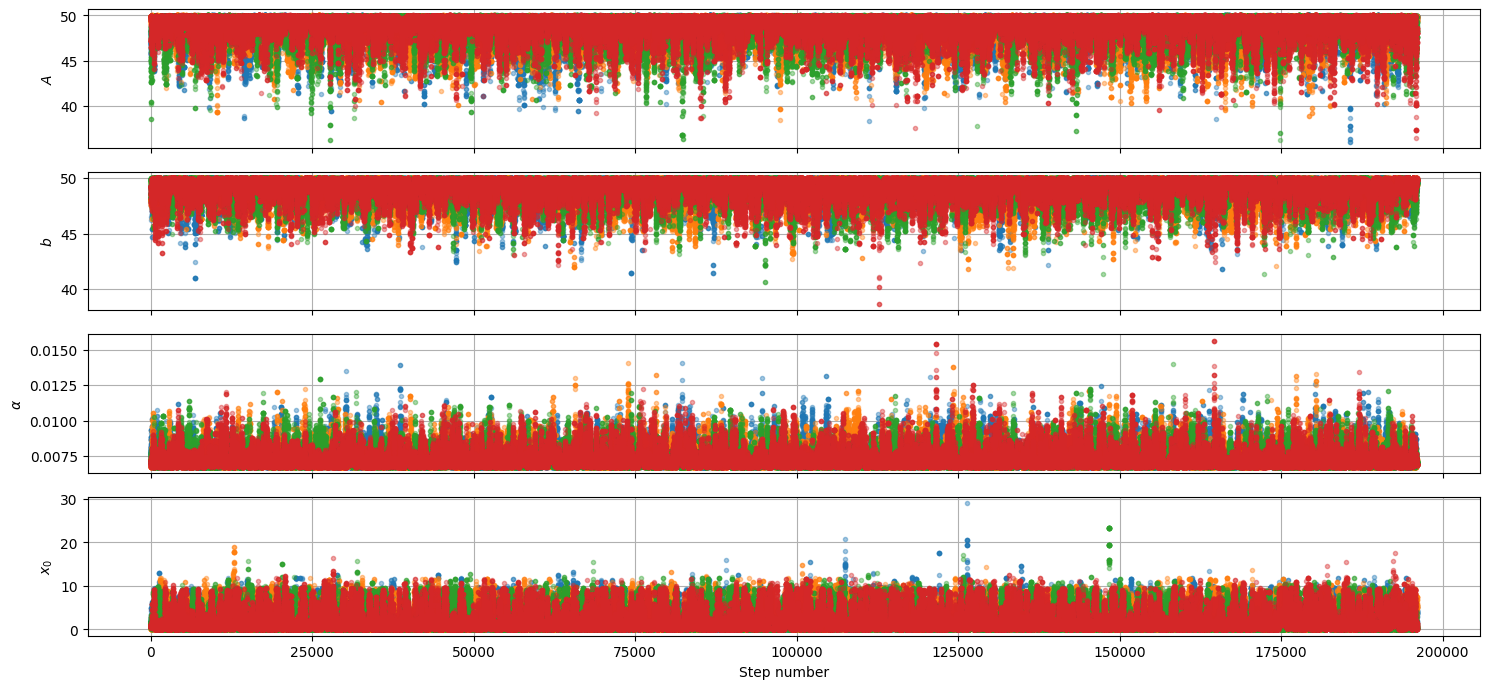

In [28]:
labels = [r"$A$", r"$b$", r"$\alpha$", r"$x_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[4000:, ::5, i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


Cut first 1000 points

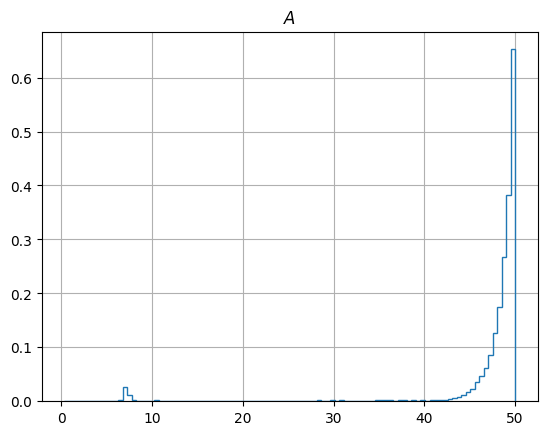

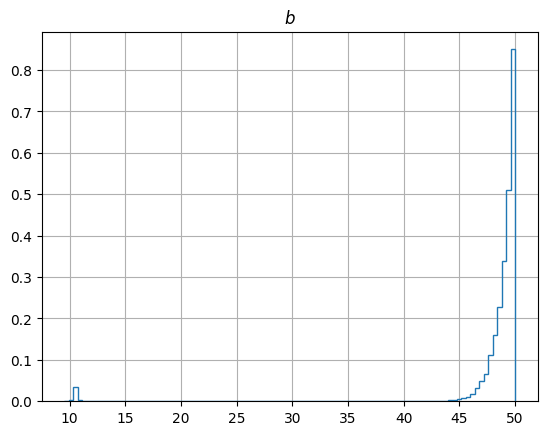

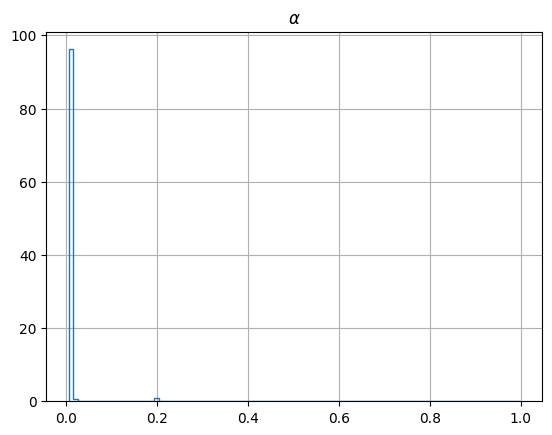

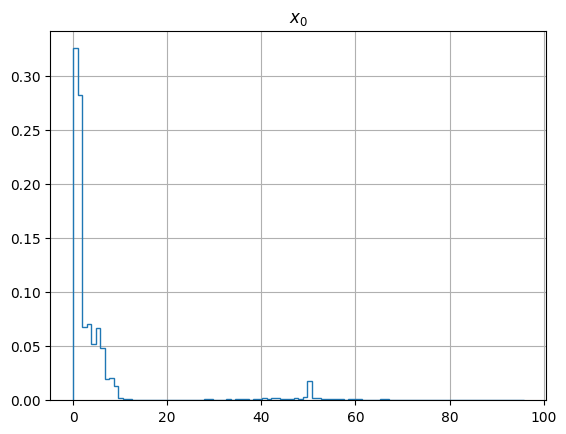

In [29]:
for i in range(4):
    plt.hist(samples[:4000, :, i].flatten(), bins=100, density=True, histtype='step', label=labels[i])
    plt.grid()
    plt.title(labels[i])
    plt.show()

In [30]:
flat_samples = sampler.get_chain(discard=10000, thin=30, flat=True)

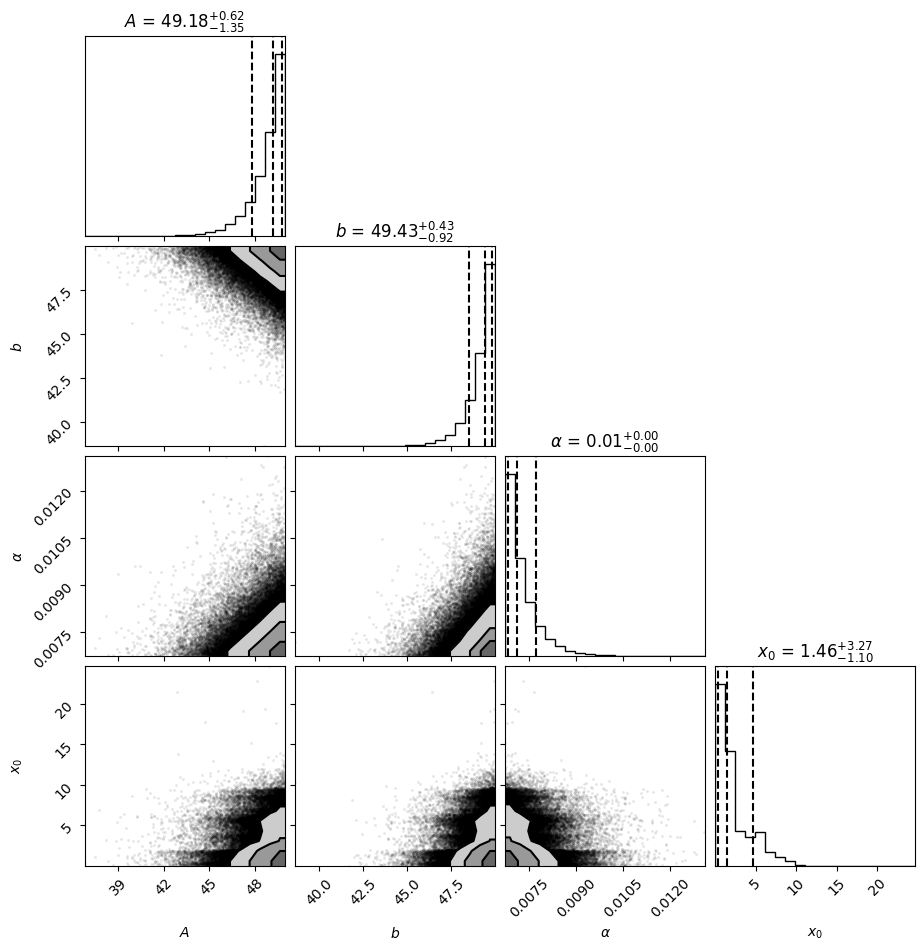

In [31]:
fig = corner.corner(flat_samples, labels=labels, truths=guess_parameters, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, fill_contours=True);

We can try now with PyMC

In [33]:
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
